In [ ]:
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 7.0 MB/s 


# Quick Tour a ALerCe
Con este notebook prenderas a hacer querys a la enorme base de datos de Alerce

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

import psycopg2 

import json
import requests
# se utiliza el json de este github que contiene las claves para hacer querys
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

# se abre la conexión usando los parametros del json
conn = psycopg2.connect(
    dbname=params['dbname'], user=params['user'], 
    host=params['host'], password=params['password']
    )



explorar la gran variedad de tablas en existencia

Las tablas más relevantes para comenzar a explorar la base de datos son:

- object: un objeto por fila, estadisticas basicas del objeto

- non_detection: una fila por no-deteccion por objeto, las magnitudes limitantes (aquellas que estan dentro de lo normal para el objeto)

- detection: una fila por deteccion, curvas de luz y otra información relacionada al tiempo de ocurrencia








In [ ]:
# esta celda te entregara una lista de tablas
query_schema = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query_schema , conn)

tables.head()

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version


In [ ]:
# este es el query mas simple posible, seleccionamos todo
query = """
SELECT * FROM object LIMIT 1000
;
"""
df = pd.read_sql_query(query, conn)

df.head()


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,meanra,meandec,sigmara,sigmadec,deltajd,firstmjd,lastmjd,step_id_corr,diffpos,reference_change
0,ZTF19abhlhyy,18,905,58607.50,59732.50,False,False,3,NaN,NaN,...,272.364875,-20.867891,0.000088,0.000097,22.961921,59709.417847,59732.379769,1.1.2,True,False
1,ZTF22aamjeci,1,1156,59732.25,59732.25,False,False,1,NaN,NaN,...,210.084979,-19.044289,NaN,NaN,0.000000,59732.253310,59732.253310,1.1.2,True,False
2,ZTF22aamjejx,1,955,59732.25,59732.25,False,False,1,NaN,NaN,...,215.706765,11.226265,NaN,NaN,0.000000,59732.255185,59732.255185,1.1.2,True,False
3,ZTF22aamjemj,1,711,59732.25,59732.25,False,False,1,NaN,NaN,...,212.657198,-16.083068,NaN,NaN,0.000000,59732.253310,59732.253310,1.1.2,True,False
4,ZTF22aamjemm,1,621,59732.25,59732.25,False,False,1,NaN,NaN,...,224.974799,-21.222143,NaN,NaN,0.000000,59732.251898,59732.251898,1.1.2,True,False


la tabla de objeto tiene 20 coilumnas, aqu algunas:

### Position

- meanra, meandec
- sigmara, sigmadec

### Colors:

- g-r max, min

### Time:

- firstmjd (First detection)
- lastmjd (Last detection)
- deltamjd (lastmjd - firstmjd)

### Detection Statistics:

- ndet (Number of alerts)

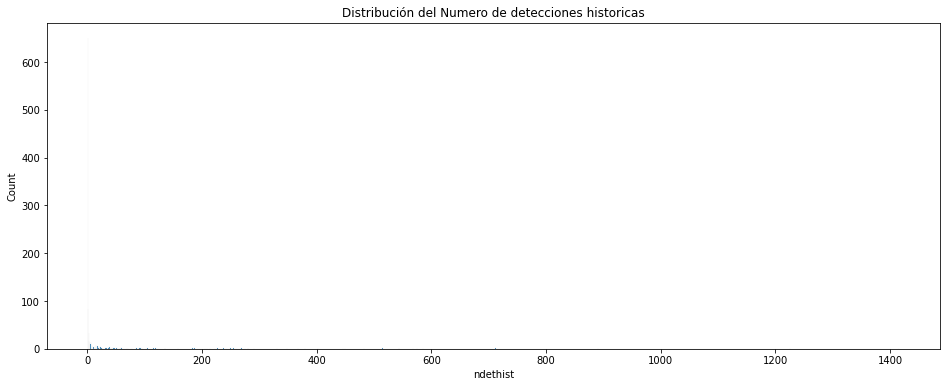

In [ ]:
plt.subplots(figsize=(16,6))
sn.histplot(df.ndethist)
plt.title('Distribución del Numero de detecciones historicas')
plt.show()

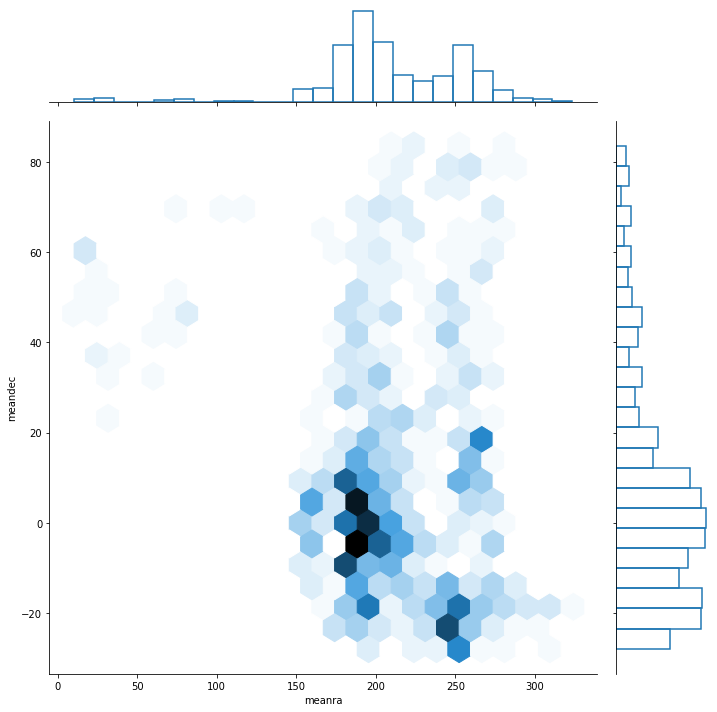

In [ ]:
# puedes ver donde se encuentra el promedio de las coordenadas de los datos
sn.jointplot(x= df.meanra,y= df.meandec,  kind="hex", height=10,
             marginal_kws=dict(bins=25, fill=False))

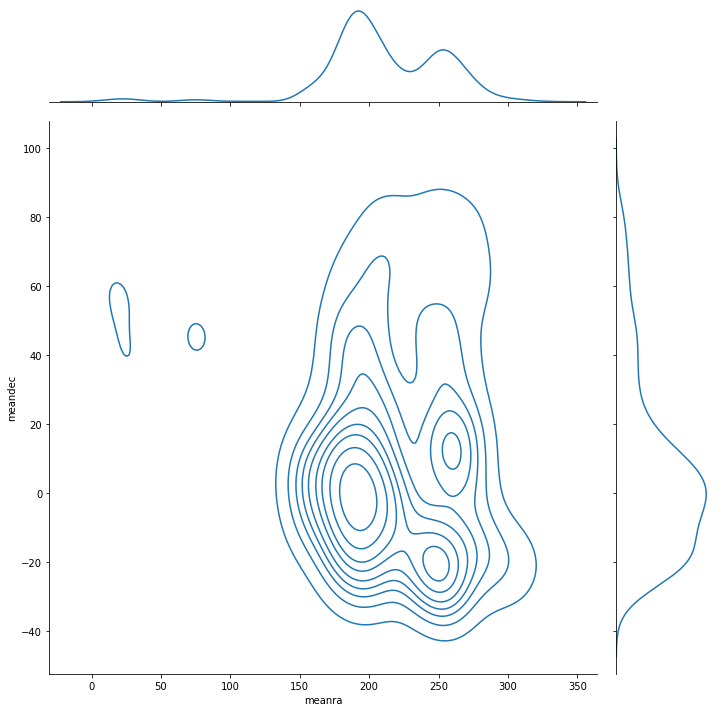

In [ ]:
# puedes ver donde se encuentra el promedio de las coordenadas de los datos
sn.jointplot(x= df.meanra,y= df.meandec,  kind="kde", height=10)

# por default kind incluye rangos mas grandes
# en comparacion a hex

# jointplot es una forma interesante de mostrar relación entre distribuciones

## mezclar

In [ ]:
# esta celda te entregara una lista de tablas
query = """
SELECT * FROM probability LIMIT 200;
"""

pd.read_sql_query(query, conn).columns

# probability tiene el oid : object_id
# la probabilidad de su clae y el clasifado usado para eso

Index(['oid', 'classifier_name', 'classifier_version', 'class_name',
       'probability', 'ranking'],
      dtype='object')

In [ ]:
# probability es util para mezclarse con otros:
query = """
SELECT * FROM detection LIMIT 100;
"""

pd.read_sql_query(query, conn).columns
# nota que se encuentra la misma columna llamada oid, hacen referencia al mismo objeto

Index(['oid', 'candid', 'mjd', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'ra', 'dec', 'magpsf', 'sigmapsf', 'magap', 'sigmagap', 'distnr', 'rb',
       'rbversion', 'drb', 'drbversion', 'magapbig', 'sigmagapbig', 'rfid',
       'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'corrected',
       'dubious', 'parent_candid', 'has_stamp', 'step_id_corr'],
      dtype='object')

Dividamos el siguiente query en distintas partes, esta es una query que toma dos tablas y las mezcla
```sql
SELECT tabla1.columna1, tabla1.columna2, tabla2.columna1
```
Luego la siguiente parte es donde ocurre la magia, se usaran `#` para comentarios, aunque esto no es para comentarios en SQL:
```sql
# FROM define desde que tabla se obtiene
FROM
    # se toma detection y se combina, a eso va el Join
    # el join adentro posee otra query SQL
    detection INNER JOIN (
        # Query interna
    ) AS probability_oid # le da un nombre nuevo al resultado
    # indica con que regla se combinan, en este caso la id de los objeos
    ON detection.oid=probability_oid.oid
    # limita la cantidad de quert
    LIMIT 3000
```

La query interna puede verse por si sola, y el resultado de esa query se entrega como `probability_oid`

```sql
  # selecciona id de objetos, nombre clasificador, clase, ranking y la probabilidad
  SELECT
      oid, classifier_name, class_name, ranking, probability
  # lo selecciona de la tabla de probabilidad
  FROM 
      probability 
  # condiciones para lo que nos entrega
  WHERE
      ranking in (1,2)
      AND probability > 0.6

```



In [ ]:
query='''
SELECT
    detection.oid, detection.ra, detection.dec,
    probability_oid.classifier_name, probability_oid.class_name,
    probability_oid.ranking, probability_oid.probability
FROM
    detection INNER JOIN (
    SELECT
        oid, classifier_name, class_name, ranking, probability
    FROM
        probability
    WHERE
        ranking in (1,2)
        AND probability > 0.6

    ) AS probability_oid

    ON detection.oid=probability_oid.oid

    LIMIT 3000

'''

objects = pd.read_sql_query(query, conn)
print(objects.shape)
objects.set_index('oid', inplace=True)
objects.head()

(3000, 7)


,ra,dec,classifier_name,class_name,ranking,probability
oid,,,,,,
ZTF18abluvun,279.002242,-15.633897,lc_classifier,LPV,1,0.62484
ZTF18abluvun,279.002349,-15.633988,lc_classifier,LPV,1,0.62484
ZTF18abluvun,279.002287,-15.633888,lc_classifier,LPV,1,0.62484
ZTF18abluvun,279.002287,-15.633873,lc_classifier,LPV,1,0.62484
ZTF18abluvun,279.002261,-15.633916,lc_classifier,LPV,1,0.62484


resumen de la query anterior,




In [ ]:
# el total de index
set(objects.index)

{'ZTF18aapudwi',
 'ZTF18aasfzqj',
 'ZTF18abaqxlh',
 'ZTF18abarata',
 'ZTF18abgopzh',
 'ZTF18abhaxxw',
 'ZTF18abliydw',
 'ZTF18abliydx',
 'ZTF18abljasc',
 'ZTF18abmnvnm',
 'ZTF18abnbwyb',
 'ZTF18acdahry',
 'ZTF18acirnpt',
 'ZTF18actzrts',
 'ZTF18adjwqmb',
 'ZTF18adkpqox',
 'ZTF19aaycqcy',
 'ZTF20acekgbq',
 'ZTF20acmngye',
 'ZTF20acnssob'}

In [ ]:
# todo lo que aparece en esta lista son:
set(objects.class_name)

{'AGN', 'Blazar', 'E', 'LPV', 'Periodic-Other', 'QSO', 'RRL'}

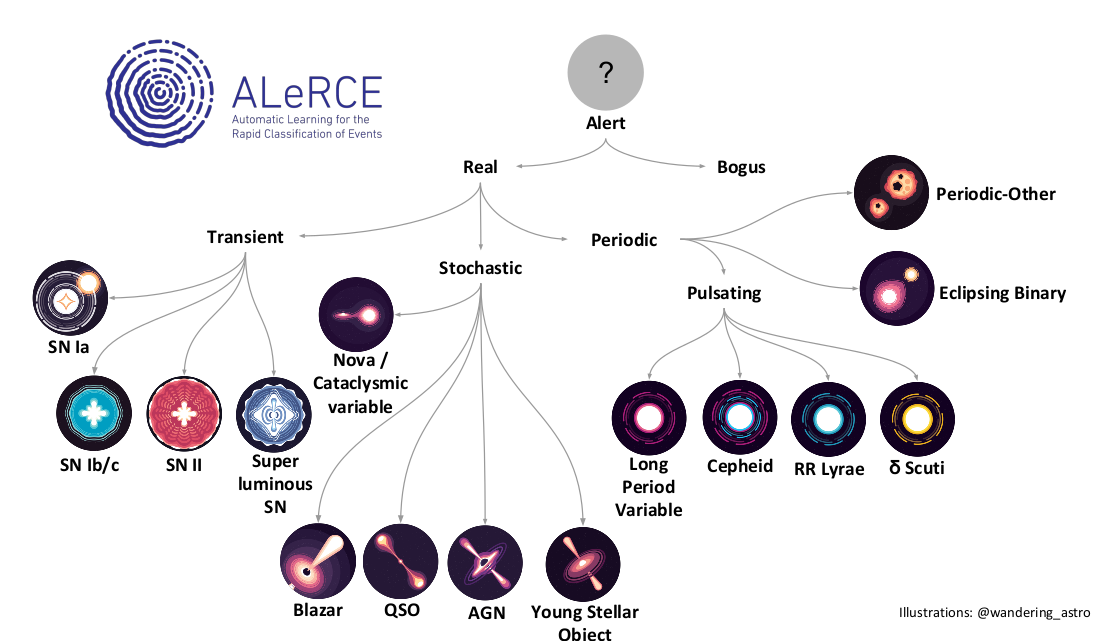

se puede visitar: [guia columnas](https://docs.google.com/spreadsheets/d/1OH3Dz-s8pWy-cY2FuT59miItHMrpIRm1aOVCRTPwLGA/edit?usp=sharing)

In [ ]:
# aqui objetos capaces de ser QSO
#especificamos que elija la clase QSO y una probabilidad mayor a 0.85
qso_candidatos = objects[(objects.class_name == 'QSO') & (objects.probability > 0.85)]
qso_candidatos.head()

,ra,dec,classifier_name,class_name,ranking,probability
oid,,,,,,
ZTF19aaycqcy,357.650103,34.402711,lc_classifier,QSO,1,0.866768
ZTF19aaycqcy,357.650139,34.402639,lc_classifier,QSO,1,0.866768
ZTF19aaycqcy,357.650028,34.402731,lc_classifier,QSO,1,0.866768
ZTF19aaycqcy,357.650147,34.402698,lc_classifier,QSO,1,0.866768
ZTF19aaycqcy,357.650183,34.402702,lc_classifier,QSO,1,0.866768


In [ ]:
# seleccionamos uno de los objetos con maxima probabilidad
qso1 = qso_candidatos[qso_candidatos.probability == qso_candidatos.probability.max()].iloc[2]
qso1

ra                    357.650028
dec                    34.402731
classifier_name    lc_classifier
class_name                   QSO
ranking                        1
probability             0.866768
Name: ZTF19aaycqcy, dtype: object

In [ ]:
# Use the example code from Aladin Lite
def observar_cielo(ra, dec):
  query = """

<link rel="stylesheet" href="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.css" />
 
<script type="text/javascript" src="https://code.jquery.com/jquery-1.12.1.min.js" charset="utf-8"></script>
<div class="titulo">Visualizacion Aladin</div>
<div id="aladin-lite-div" style="width:800px;height:600px;"></div>
<script type="text/javascript" src="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.js" charset="utf-8"></script>
<script type="text/javascript">
    var aladin = A.aladin('#aladin-lite-div', {survey: "P/PanSTARRS/DR1/color-z-zg-g", fov:0.04, target: "%s, %s"});
</script>

    
""" % (float(ra), float(dec))
  display(HTML(query))


def observar_objeto(object):
  try: # intenta obtener la coordenada
    ra, dec = object.ra, object.dec
  except: # en caso de que el objeto no posea ra y dec, probablemente es meanra, meandec
    ra, dec = object.meanra, object.meandec
  # luego usa la funcion que llama a Aladain
  observar_cielo(ra, dec)



In [ ]:
# this uses the results from the last getSNdata call
observar_cielo(qso1.ra, qso1.dec)

In [ ]:
#objetos unicos
# para hacerle la vida mas simple al lector, aqui simplifico
# y quito los objetos repetidos, probemos suerte y digamos que solo es la primera posibilidad
# eso quiere decir quitar los repetidos y dejar el primero
objetos = objects.groupby(objects.index).first()
objetos

,ra,dec,classifier_name,class_name,ranking,probability
oid,,,,,,
ZTF18aapudwi,248.229415,46.076421,lc_classifier,E,1,0.690000
ZTF18aasfzqj,257.756453,48.321204,lc_classifier,AGN,1,0.802604
ZTF18abaqxlh,291.584885,1.044113,lc_classifier,LPV,1,0.634432
ZTF18abarata,288.482939,3.186040,lc_classifier,LPV,1,0.896280
ZTF18abgopzh,328.030319,59.471636,lc_classifier,Periodic-Other,1,0.653868
ZTF18abhaxxw,246.598761,74.792370,lc_classifier,E,1,0.773332
ZTF18abliydw,287.220465,12.190155,lc_classifier,LPV,1,0.659680
ZTF18abliydx,287.375591,12.366829,lc_classifier,LPV,1,0.600704
ZTF18abljasc,287.677514,11.347275,lc_classifier,LPV,1,0.774336


In [ ]:
observar_objeto(objetos.iloc[2])

# SQL en profundidad
Selecciona un objeto de la base de datos con su `oid` (object identifier), es posible seleccionar dadas ciertas condiciones

In [ ]:
query_agn_examples='''

  SELECT
      oid, classifier_name, class_name, ranking, probability
  FROM
      probability
  WHERE
      class_name='AGN'
      AND probability > 0.6

  LIMIT 1000

'''

agn_examples = pd.read_sql_query(query_agn_examples, conn)
agn_examples.set_index('oid', inplace=True) # el index sera el objeto
    # comodo, pero cuidado pues hay indices repetidos y algunos se sobreescribiran
    # es importante tener un conocimiento de la data
agn_examples.head()

,classifier_name,class_name,ranking,probability
oid,,,,
ZTF20aazfzrw,lc_classifier,AGN,1,0.834416
ZTF18abuapqg,lc_classifier,AGN,1,0.840336
ZTF21aapfjnr,lc_classifier,AGN,1,0.700608
ZTF19aaskiof,lc_classifier,AGN,1,0.816408
ZTF19abmsizx,lc_classifier,AGN,1,0.733752


In [ ]:
query_agn ='''
SELECT
    object.*
FROM
    object INNER JOIN (
      SELECT
        oid, class_name, probability
      FROM
        probability
      WHERE
        class_name='AGN'
        AND probability > 0.6

    ) AS probability_oid

    ON object.oid=probability_oid.oid

    LIMIT 200
  '''


agn = pd.read_sql_query(query_agn, conn)
agn.set_index('oid', inplace=True)
agn.head()

,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,meanra,meandec,sigmara,sigmadec,deltajd,firstmjd,lastmjd,step_id_corr,diffpos,reference_change
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18adlyckc,556,3692,58304.25,59785.25,True,False,21,-0.037700,0.275503,0.205809,...,250.224906,45.433741,0.000045,0.000032,59.897072,59725.347396,59785.244468,dev,False,False
ZTF19acyjyhx,507,671,58634.25,59928.25,True,False,378,0.241869,0.374002,0.203488,...,128.385405,82.783536,0.000180,0.000028,1094.903600,58833.444583,59928.348183,1.1.6,False,False
ZTF21ackuivm,46,409,58757.50,59874.50,True,False,8,-0.090543,0.483826,0.281194,...,81.108843,-24.856878,0.000055,0.000038,355.996412,59518.443368,59874.439780,1.1.6,False,False
ZTF18aarboae,1147,1988,58245.25,59930.50,True,False,410,0.205568,0.712162,0.341512,...,140.330749,50.281780,0.000073,0.000046,1555.888102,58374.512153,59930.400255,1.1.6,False,True
ZTF18aarmyhp,283,1943,58256.25,59726.25,True,False,99,-0.225500,0.340027,-0.003308,...,180.631637,22.622766,0.000062,0.000059,1162.945903,58567.255451,59730.201354,1.1.2,True,False


In [ ]:
agn.columns

Index(['ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist', 'corrected',
       'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'meanra', 'meandec', 'sigmara', 'sigmadec', 'deltajd',
       'firstmjd', 'lastmjd', 'step_id_corr', 'diffpos', 'reference_change'],
      dtype='object')

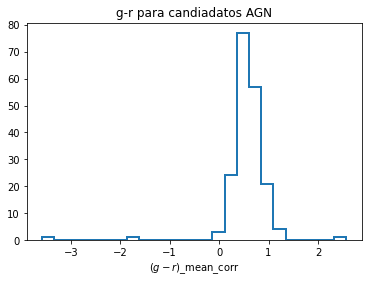

In [ ]:
fig, ax = plt.subplots()

# hisotograma, con linewidth = 2
ax.hist(agn.g_r_mean_corr,histtype='step', bins=25, lw=2)
# seteamos informacion
ax.set_xlabel(r"($g-r$)_mean_corr")
ax.set_title('g-r para candiadatos AGN')
plt.show()

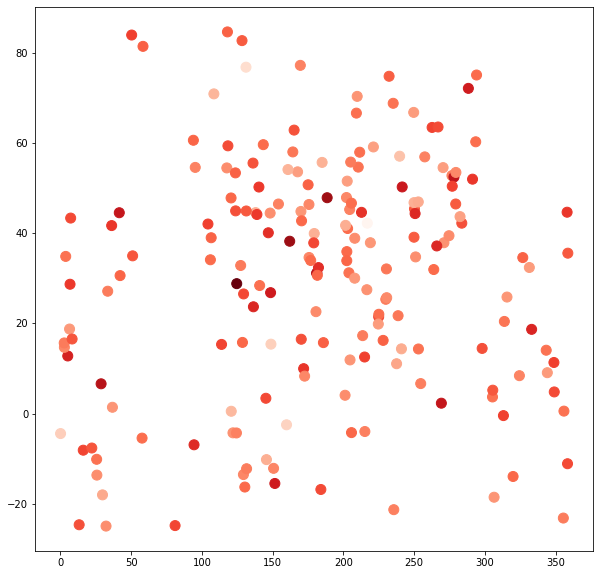

In [ ]:
import matplotlib

fig, ax = plt.subplots(figsize=(10, 10))
        
ax.scatter(agn.meanra, agn.meandec, c=agn.g_r_mean, cmap="Reds", marker='o', s=100)

In [ ]:
query_angle ='''

  SELECT
      oid, meanra, meandec
  FROM
      object
  WHERE meanra BETWEEN 0 AND 350
  AND meandec BETWEEN -25 AND 90

  LIMIT 3000
'''

cone = pd.read_sql_query(query_angle , conn)
# cone.set_index('oid', inplace=True)
cone.head()

,oid,meanra,meandec
0,ZTF18abixytz,260.260670,78.198832
1,ZTF18acvwdgl,207.113095,22.412478
2,ZTF19aaloypo,240.960991,76.646584
3,ZTF19aaedyck,253.369410,6.102506
4,ZTF19aayxwji,249.187548,-23.242263


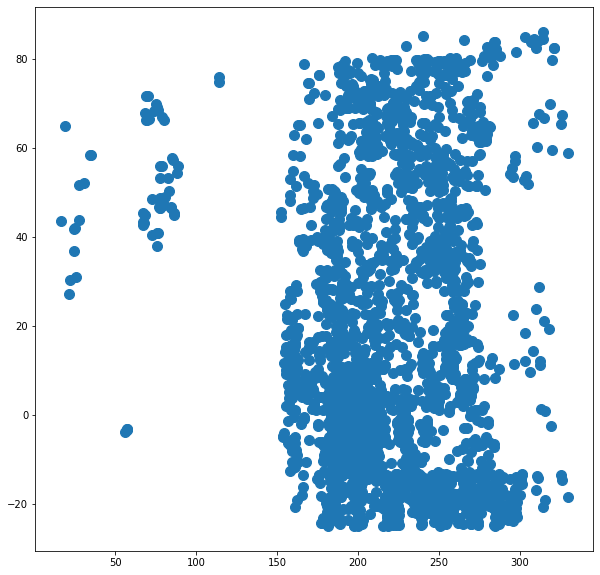

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
        
ax.scatter(cone.meanra, cone.meandec, marker='o', s=100)


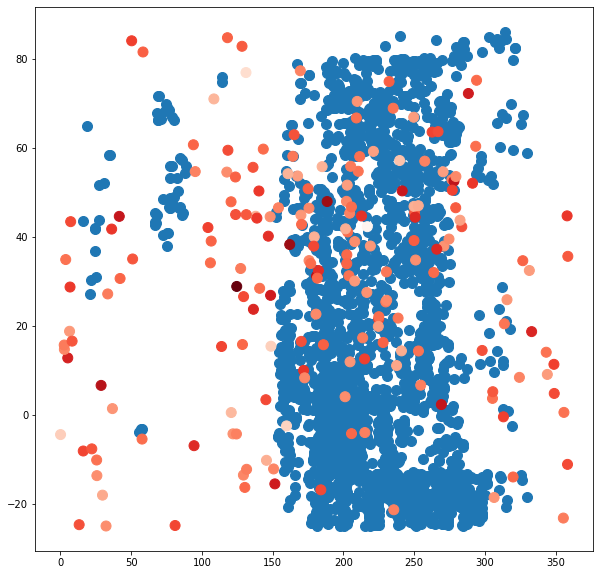

In [ ]:
# subplots permite crear varios plots, yo lo suelo utilizar para definir size
# de la figura
fig, ax = plt.subplots(figsize=(10, 10))

# aqui comparo observaciones
ax.scatter(cone.meanra, cone.meandec, marker='o', s=100)
# con los posibles agn
ax.scatter(agn.meanra, agn.meandec, c=agn.g_r_mean, cmap="Reds", marker='o', s=100)
# de manera que algo de crear algo intuición para el lector 

# es util agregar variabilidades mediante el color, pero siempre teniendo cuidado
# de sobrecargar la imagen

# notece los espacios, estos se deben a que se corrio con un LIMIT
# por tanto entiendase que la sección mas poblada es mas cercana a la realidad